# 概要
- 分析の目的
  - 特定保健指導が血圧に与える影響を明らかにする
- 施策の内容
  - 腹囲85以上の方を対象に特定保健指導を実施した（実際の特定保健指導の対象とは異なります）
  - 特定保健指導対象を介入群、非対象を非介入群とする
- 下記のサンプルデータを作成する
  - 真の平均介入効果を血圧-5とする
- データ概要
  - 結果変数：血圧
  - 処置変数：特定保健指導
  - ランニング変数：腹囲
  - カットオフ：85

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from rdd import rdd
from rdrobust import rdrobust, rdplot
import rddensity

import math

# サンプルデータ作成

In [2]:
# シード値を固定
np.random.seed(0)

# サンプルサイズを1,000とする
n=1_000

# 閾値の設定
threshold=85

# 腹囲
X=np.random.uniform(60,110,size=n)
treatment=(X>=threshold).astype(int)


# BP(blood_pressure：血圧)
# 介入前の血圧
_BP=55+0.85*X+ np.random.normal(0, 5, size=n)
# 介入群の血圧が5低くなるようにする
BP=_BP -5*treatment + np.random.normal(0, 2, size=n)

# データフレームの作成
df=pd.DataFrame({'血圧':BP
                 ,'腹囲':X
                 ,'treatment':treatment
                })

# 可視化

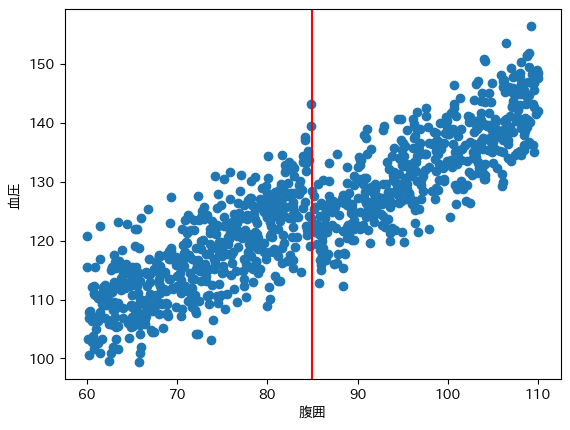

In [3]:
plt.scatter(df['腹囲'], df['血圧'])
plt.xlabel('腹囲')
plt.ylabel('血圧')
plt.axvline(x=threshold, color='r')
plt.show()
plt.close()

# 単純な平均値の比較

In [4]:
print(df[df['treatment']==1]['血圧'].mean()-df[df['treatment']==0]['血圧'].mean())

15.986312946380565


介入群と非介入群を比較すると、介入群のほうが血圧が15高い値になってしまい、特定保健指導を実施すると血圧が15増加することになるため、効果をうまく推定できていないと考える

# rdrobustによる回帰不連続デザイン

## 連続性の検定
RDDによる因果効果を推定するためには連続性の仮定を満たす必要がある。rddensityを用いて連続性の検定を行う。連続性の検定では連続であることを帰無仮説、連続でないことを対立仮説としています。そのため、連続であることの証明をすることは出来ないことに留意する必要がある

In [5]:
rddensity.rddensity(X, c=threshold)

Manipulation testing using local polynomial density estimation
Number of obs:                              1000
Model:                              unrestricted
Kernel:                               triangular
BW method:                             estimated
VCE:                                   jackknife

c = 85                              Left of c             Right of c
Number of obs:                            517                    483
Eff. number of obs:                       184                    153
Order est. (p):                             2                      2
Order bias. (q):                            3                      3
BW est.                                8.6162                 8.3403

Method:                                     T                P > |T|
Robust                                  0.963                 0.3356

P-values of binomial tests (H0: p =  [0.5] ).

Window Length/2                           < c                     >= c                    

P値が0.3356のため、連続性の仮定を満たしていると判断します

## rdrobustパッケージによる推定¶

In [6]:
rdrobust(BP, X, c=threshold)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           517        483
Number of Unique Obs.            517        483
Number of Effective Obs.         112         99
Bandwidth Estimation           5.288      5.288
Bandwidth Bias                 8.851      8.851
rho (h/b)                      0.597      0.597

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -8.887     1.68   -5.289   1.232e-07  [-12.181, -5.594]
Robust                 -        -   -4.703   2.563e-06  [-13.218, -5.442]


バンド幅を5.288に設定している。  
因果効果を-8.887として推定された。つまり、特定保健指導の効果は血圧を約-8.887と推定したと考えます。
解釈の注意点として、回帰不連続デザインはカットオフ値（今回でいえば腹囲85cm）付近に限定した効果であることが挙げられます。腹囲が100cm付近への介入効果という外挿性については今回の分析からはわからないと考えます。

## rdrobust.rdplotによる可視化

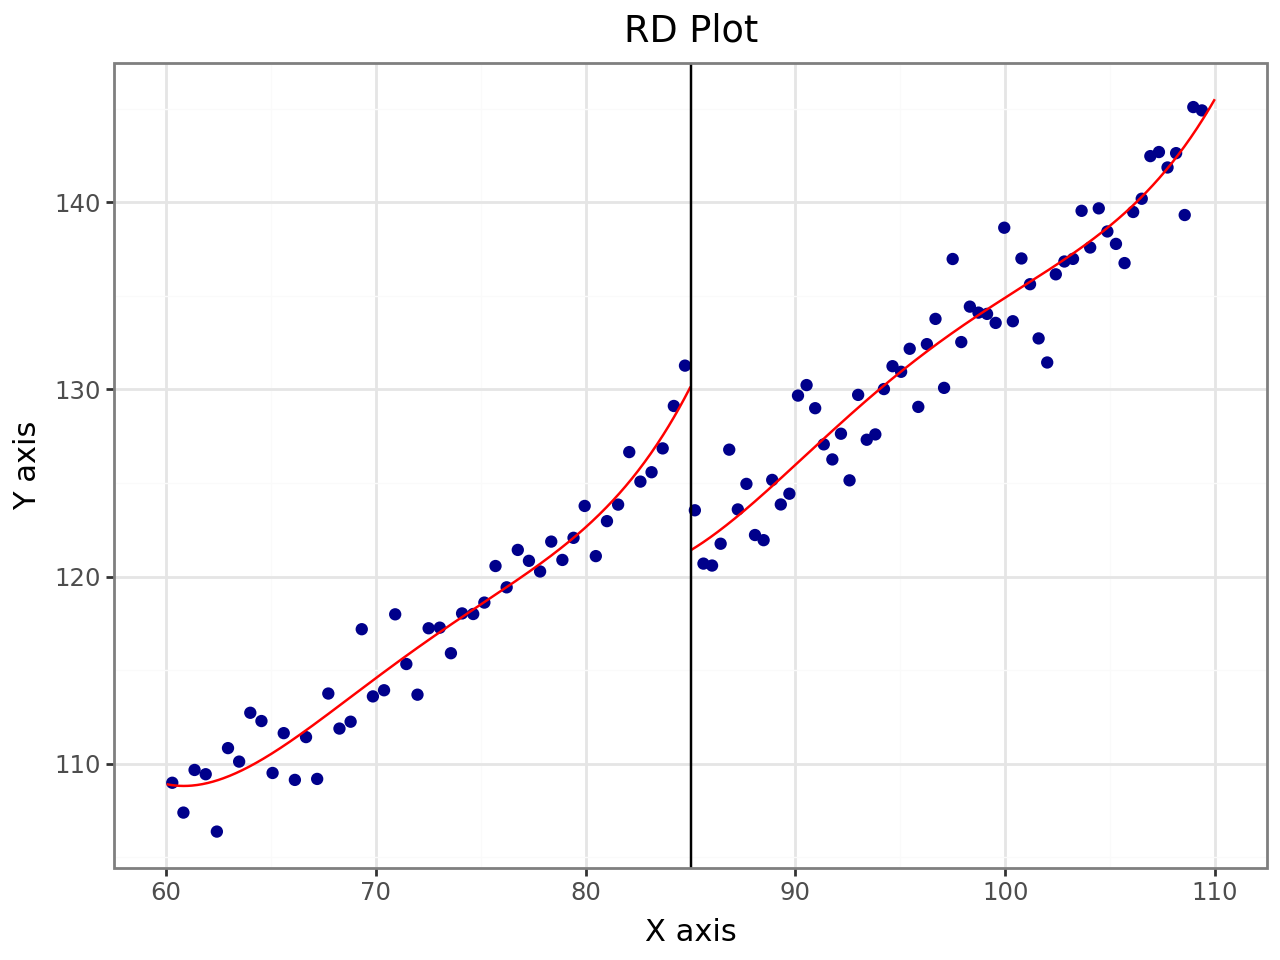


Call: rdplot
Number of Observations:                  1000
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           517        483
Number of Effective Obs          517        483
Bandwith poly. fit (h)        24.973      24.99
Number of bins scale               1          1
Bins Selected                     47         61
Average Bin Length             0.531       0.41
Median Bin Length              0.531       0.41
IMSE-optimal bins               12.0       14.0
Mimicking Variance bins         47.0       61.0

Relative to IMSE-optimal:
Implied scale                  3.917      4.357
WIMSE variance weight          0.016      0.012
WIMSE bias weight              0.984      0.988


In [7]:
rdplot(BP, X, c=threshold)

# rddパッケージによる推定
- https://pypi.org/project/rdd/

In [8]:
bandwidth_opt=rdd.optimal_bandwidth(df['血圧'], df['腹囲'], cut=threshold)
print('Optimal bandwidh', bandwidth_opt)

Optimal bandwidh 5.782860642418445


xの最小値 79.45673385505928
xの最大値 90.77797821419222


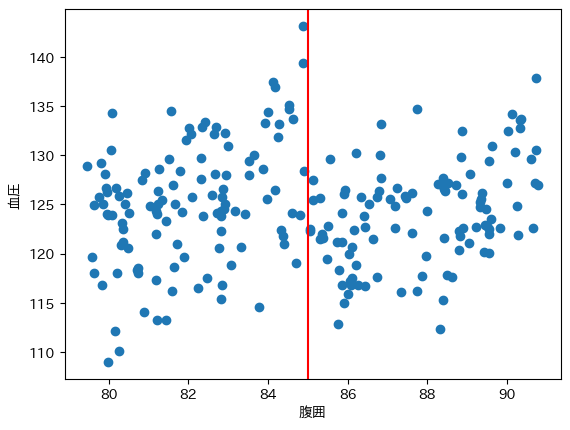

In [9]:
df_rdd=rdd.truncated_data(df, '腹囲', bandwidth_opt, cut=threshold)
print('xの最小値', df_rdd['腹囲'].min())
print('xの最大値', df_rdd['腹囲'].max())

plt.scatter(df_rdd['腹囲'], df_rdd['血圧'])
plt.xlabel('腹囲')
plt.ylabel('血圧')
plt.axvline(x=threshold, color='r')
plt.show()
plt.close()

In [10]:
model=rdd.rdd(df_rdd, '腹囲', '血圧', cut=threshold)
print(model.fit().summary())

Estimation Equation:	 血圧 ~ TREATED + 腹囲
                            WLS Regression Results                            
Dep. Variable:                     血圧   R-squared:                       0.153
Model:                            WLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     19.89
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.14e-08
Time:                        11:46:24   Log-Likelihood:                -690.97
No. Observations:                 224   AIC:                             1388.
Df Residuals:                     221   BIC:                             1398.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   